<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dimensionality Reduction</a></span><ul class="toc-item"><li><span><a href="#Save-off-texts-for-LDA" data-toc-modified-id="Save-off-texts-for-LDA-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Save off texts for LDA</a></span></li><li><span><a href="#Perform-LDA" data-toc-modified-id="Perform-LDA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Perform LDA</a></span><ul class="toc-item"><li><span><a href="#Make-Dictionary-/-TF-IDF-model" data-toc-modified-id="Make-Dictionary-/-TF-IDF-model-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Make Dictionary / TF-IDF model</a></span><ul class="toc-item"><li><span><a href="#Dictionary" data-toc-modified-id="Dictionary-3.2.1.1"><span class="toc-item-num">3.2.1.1&nbsp;&nbsp;</span>Dictionary</a></span></li><li><span><a href="#BOW-Corpus" data-toc-modified-id="BOW-Corpus-3.2.1.2"><span class="toc-item-num">3.2.1.2&nbsp;&nbsp;</span>BOW Corpus</a></span></li><li><span><a href="#TFIDF-Corpus" data-toc-modified-id="TFIDF-Corpus-3.2.1.3"><span class="toc-item-num">3.2.1.3&nbsp;&nbsp;</span>TFIDF Corpus</a></span></li></ul></li><li><span><a href="#Train-LDA" data-toc-modified-id="Train-LDA-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Train LDA</a></span></li></ul></li><li><span><a href="#Test-LDA" data-toc-modified-id="Test-LDA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Test LDA</a></span></li></ul></li><li><span><a href="#Regressions" data-toc-modified-id="Regressions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regressions</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting</a></span></li></ul></div>

To cover today:

  1. Quick run through pipeline getting text into gensim
  1. Dimensionality reduction (LDA)
  1. direct use or similarity
  1. Input to regressions
  1. Regression/graphical output

# Imports

In [103]:
%run imports.ipynb

import json
import pickle
from wordcloud import WordCloud

MODEL_ROOT = os.path.join("..", 'LDA')
if not os.path.exists(MODEL_ROOT):
    os.mkdir(MODEL_ROOT)
    
def GET_MODEL(*x):
    pth = os.path.join(MODEL_ROOT, *x)
    if not os.path.exists(os.path.dirname(pth)):
        os.mkdir(os.path.dirname(pth))
    return os.path.abspath(pth)
    
print(GET_MODEL(''))

Set LOG_LEVEL="WARNING" before running the import file to reduce the clutter.
Set LOG_FORMAT="%(levelname)s::%(message)s" to change log format.
IPython: 7.25.0
Numpy (np): 1.21.4
Scipy (sp, stats): 1.7.0
Pandas (pd): 1.3.0
MatPlotLib (mpl, plt): 3.5.0
Seaborn (sns): 0.11.2
Scikit-Learn (sk): 0.24.2
Statsmodels (sm): 0.12.2
Patsy (pt): 0.5.1
SQLAlchemy (sa): 1.4.21
Gensim: 4.0.1
/home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA


# Load Data

In [9]:
DB = os.path.expanduser('~/Dropbox/Documents/School/_data/big/risk factors/')
!ls "{DB}" | head -n 1

rf_individual_fyear-2004_2021-12-02.xlsx


In [50]:
if False: # don't overwrite because load took 20 minutes
    df_rf = []
    for file in os.scandir(DB):
        df_rf.append(pd.read_excel(file.path))
    df_rf = pd.concat(df_rf)
    
    df_rf = df_rf[(df_rf.next_item==0) & (df_rf.text.str.len() > 100)]
df_rf.head(1)

,accession,cik,name,form,next_item,header,header_number,header_start,header_end,text_end,text,filedate
3,0001448788-09-000244,1088787,"China Direct Industries, Inc.",10-K,0,RISK FACTORS,2,27,47,1875,RISK FACTORS\nThe risk factors in this section...,2010-01-04


In [35]:
from cpn import config
from cpn.data.sources.compustat import CompustatAnnual
df_comp = CompustatAnnual().data
df_link = pd.read_csv(os.path.join(config.DATA_DIR_INTERIM, "all_gvkey_cik_pairs.tab"),
                      sep='\t')

In [206]:
df_data = (
    df_comp[df_comp.S('gvkey fyear datadate rdq at mve ni ebit xrd btm '
                      'lev_book zscore_public liquidity tangibility')]
    .merge(df_link)
    .merge(df_rf[S('cik accession filedate')].drop_duplicates())
    .query('filedate > datadate')
    .assign(diff=lambda x: (x.filedate - x.datadate)/TD_DAY)
    .sort_values(S('cik fyear diff'))
    .drop_duplicates(S('cik fyear datadate'))
)
df_data.head(1)

,gvkey,fyear,datadate,rdq,at,mve,ni,ebit,xrd,btm,lev_book,zscore_public,liquidity,tangibility,cik,accession,filedate,diff
598483,6314,1991,1991-12-31,1992-02-27,71.022,23.888,3.653,6.908,3.598,1.078,0.379,2.452,1.964,0.297,20,0000893220-06-000650,2006-03-23,5196


In [75]:
KEEP_ACCESSIONS = df_rf.accession.isin(df_data.accession)
len(df_rf[KEEP_ACCESSIONS])

2250412

# Dimensionality Reduction

## Save off texts for LDA

In [73]:
import ipyparallel as ipp
IP_client = ipp.Client()
print(IP_client.ids)
IP_view = IP_client.load_balanced_view()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [ ]:
txt = df_rf[KEEP_ACCESSIONS].text.values[0]

In [88]:
%%px --local

import re
from nltk.corpus import stopwords

_stop_words = stopwords.words('english')

# Using the word finder from last time
re_word_finder = re.compile(
    r'\b' # word-boundry, so match beginning or ends of words
    r"(?:[a-z][\w\-'’]*[a-z])" # Add ’, which is single quote and end quote
    r'\b' # ending word-boundry
    , re.IGNORECASE
)

def clean_text(text):
    try:
        return list(filter(lambda x: x not in _stop_words, 
                           re_word_finder.findall(text.lower())))
    except Exception as e:
        return [str(e)]

In [90]:
async_result = IP_view.map(lambda x: clean_text(x),
                           df_rf[KEEP_ACCESSIONS].text.values,
                           chunksize=1000,
                           ordered=False)

In [94]:
from time import sleep
from ipywidgets import Output, IntProgress, HTML as wHTML
queue_len = len(async_result.status)
tot_num = len(df_rf[KEEP_ACCESSIONS])

txt = wHTML(value=f'Processing {queue_len} w/ {tot_num // queue_len} per')
prog = IntProgress(
        value=async_result.progress,
        min=0,
        max=len(async_result.status),
        step=1,
        description=f'Processing {queue_len} w/ {tot_num // queue_len} per:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
display(txt, prog)

while not async_result.done():
    prog.value = async_result.progress
    txt.value = (f'Processing {async_result.progress} of {queue_len} '
                 f'({100*async_result.progress/queue_len:7.2f}% @ {tot_num // queue_len} per)')
    sleep(10)

HTML(value='Processing 2251 w/ 999 per')

IntProgress(value=2251, description='Processing 2251 w/ 999 per:', max=2251)

In [97]:
texts = async_result.result()

In [100]:
len(texts), len(texts[0]), min(map(len, texts))

(2250412, 144, 3)

In [104]:
import json
with open(GET_MODEL('texts.json'), 'w') as fh:
    json.dump(texts, fh)

## Perform LDA

### Make Dictionary / TF-IDF model

In [105]:
CORPUS = texts

In [208]:
print(CORPUS[0])

['risk', 'factors', 'risk', 'factors', 'section', 'describe', 'major', 'risks', 'business', 'prospects', 'results', 'operations', 'financial', 'condition', 'cash', 'flows', 'considered', 'carefully', 'addition', 'factors', 'constitute', 'cautionary', 'statements', 'private', 'securities', 'litigation', 'reform', 'act', 'could', 'cause', 'actual', 'results', 'differ', 'materially', 'projected', 'forward-looking', 'statements', 'defined', 'act', 'made', 'transition', 'report', 'form', 'investors', 'place', 'undue', 'reliance', 'forward-looking', 'statements', 'statements', 'historical', 'facts', 'express', 'involve', 'discussions', 'expectations', 'beliefs', 'plans', 'objectives', 'assumptions', 'future', 'events', 'performance', 'often', 'always', 'use', 'words', 'phrases', 'likely', 'result', 'expected', 'continue', 'anticipated', 'estimated', 'intends', 'plans', 'believes', 'projects', 'may', 'forward-looking', 'may', 'involve', 'estimates', 'uncertainties', 'could', 'cause', 'actual'

#### Dictionary

##### Full Dictionary (run once)

In [106]:
dict_full = gensim.corpora.dictionary.Dictionary()

for doc in tqdm(CORPUS):
    dict_full.doc2bow(doc, allow_update=True)

dict_full.compactify()
dict_full.save(GET_MODEL('dictionary.full.dict'))

  0%|          | 0/2250412 [00:00<?, ?it/s]

INFO::Dictionary lifecycle event {'fname_or_handle': '/home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/dictionary.full.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-02-03T12:52:55.404878', 'gensim': '4.0.1', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-80-generic-x86_64-with-debian-bullseye-sid', 'event': 'saving'}
INFO::saved /home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/dictionary.full.dict


In [107]:
(pd.Series(dict_full.dfs)
 .reset_index()
 .rename(columns={0:'doc_count'})
 .assign(word=lambda x: x['index'].apply(dict_full.get),
         pct=lambda x: x.doc_count / len(CORPUS))
 .sort_values('doc_count', ascending=False)
 .reset_index(drop=True)
).query('pct > .25')

,index,doc_count,word,pct
0,55,1882826,may,0.837
1,22,1721584,could,0.765
2,9,1343770,business,0.597
3,40,1131143,financial,0.503
4,61,1107468,operations,0.492
5,92,1093254,us,0.486
6,77,1087428,results,0.483
7,76,1018364,result,0.453
8,149,969311,including,0.431
9,44,947024,future,0.421


##### Filtered Dictionary

In [108]:
if os.path.exists(GET_MODEL('dictionary.dict')):
    dictionary = gensim.corpora.dictionary.Dictionary.load(GET_MODEL('dictionary.dict'))
else:
    dictionary = gensim.corpora.dictionary.Dictionary.load(GET_MODEL('dictionary.full.dict'))

    _dict_len = len(dictionary.token2id)
    # remove stop words and words that appear only once
    dictionary.filter_extremes(no_below=1000, no_above=0.25, keep_n=1_000_000)
    dictionary.compactify()
    dictionary.save(GET_MODEL('dictionary.dict'))
    logger.warning(f"Full Dict: {_dict_len}, Compact Dict: {len(dictionary.token2id)}")
    del _dict_len

INFO::loading Dictionary object from /home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/dictionary.full.dict
INFO::Dictionary lifecycle event {'fname': '/home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/dictionary.full.dict', 'datetime': '2022-02-03T12:55:08.313890', 'gensim': '4.0.1', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-80-generic-x86_64-with-debian-bullseye-sid', 'event': 'loaded'}
INFO::discarding 167867 tokens: [('addition', 807498), ('business', 1343770), ('condition', 687120), ('could', 1721584), ('financial', 1131143), ('future', 947024), ('may', 1882826), ('new', 590992), ('operations', 1107468), ('phrases', 775)]...
INFO::keeping 7644 tokens which were in no less than 1000 and no more than 562603 (=25.0%) documents
INFO::resulting dictionary: Dictionary(7644 unique tokens: ['act', 'actual', 'always', 'anticipated', 'assess']...)
INFO::Dictionary lifecycle event {'fn

#### BOW Corpus

In [109]:
BOW_CORPUS = []
for doc in tqdm(CORPUS):
    _td = dictionary.doc2bow(doc)
    if len(_td) > 5:
        BOW_CORPUS.append(_td)

  0%|          | 0/2250412 [00:00<?, ?it/s]

In [212]:
print(BOW_CORPUS[0])

[(0, 2), (1, 3), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 6), (35, 1), (36, 1), (37, 1), (38, 7), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 3), (47, 1), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 4), (71, 6), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)]


#### TFIDF Corpus

In [111]:
try:
    tfidf_model
except NameError:
    try:
        tfidf_model = gensim.models.TfidfModel.load(GET_MODEL('tfidf.model'))
    except FileNotFoundError:
        tfidf_model = gensim.models.TfidfModel(dictionary=dictionary)
        tfidf_model.save(GET_MODEL('tfidf.model'))
finally:
    print(tfidf_model)

INFO::loading TfidfModel object from /home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/tfidf.model
INFO::TfidfModel lifecycle event {'fname_or_handle': '/home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/tfidf.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-02-03T13:17:38.299919', 'gensim': '4.0.1', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-80-generic-x86_64-with-debian-bullseye-sid', 'event': 'saving'}
INFO::saved /home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/tfidf.model


TfidfModel(num_docs=2250412, num_nnz=205759461)


In [112]:
TFIDF_CORPUS = []
for bow in tqdm(BOW_CORPUS):
    _td = tfidf_model[bow]
    if len(_td) > 5:
        TFIDF_CORPUS.append(_td)

  0%|          | 0/2249738 [00:00<?, ?it/s]

In [113]:
with open(GET_MODEL('tfidf_corpus.pkl'), 'wb') as fh:
    pickle.dump(TFIDF_CORPUS, fh)

In [211]:
print(TFIDF_CORPUS[0])

[(0, 0.08289541997653169), (1, 0.1479276239476041), (2, 0.07649521331156978), (3, 0.09758293134314282), (4, 0.07065721489962598), (5, 0.06483756154602803), (6, 0.12091427324947304), (7, 0.07538415097899526), (8, 0.03040774415734362), (9, 0.071803076272339), (10, 0.02871478335037299), (11, 0.08862743254827884), (12, 0.10366216850124599), (13, 0.09802087891415916), (14, 0.055833520732326745), (15, 0.062078943407355196), (16, 0.07865220675809874), (17, 0.06533724780390841), (18, 0.028040164883412773), (19, 0.09941585672988275), (20, 0.06489353473080019), (21, 0.10844469365382414), (22, 0.18840782005952528), (23, 0.09250997881414275), (24, 0.09276705237902029), (25, 0.06802190703400526), (26, 0.05660009353493598), (27, 0.12570470338260292), (28, 0.05873298166205254), (29, 0.04555363562990703), (30, 0.10283887593772684), (31, 0.09417644851128547), (32, 0.03945592497955986), (33, 0.16025981820723711), (34, 0.16819415513101021), (35, 0.08905167372312876), (36, 0.042475344485419335), (37, 0.05

### Train LDA

In [121]:
TOPICS = 25
PASSES = 10
ALPHA = 'asymmetric'

fn_ldam = GET_MODEL(f"lda_paragraph_T-{TOPICS}_P-{PASSES}_{ALPHA}.model")

ldam = gensim.models.LdaMulticore(
    id2word=dictionary, 
    num_topics=TOPICS,
    alpha=ALPHA,
    passes=PASSES,
    workers=20,
)
ldam.update(TFIDF_CORPUS)
ldam.save(fn_ldam)
print(f"Done with {fn_ldam}")

INFO::LdaState lifecycle event {'fname_or_handle': '/home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/lda_paragraph_T-25_P-10_asymmetric.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-02-03T14:09:26.997871', 'gensim': '4.0.1', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-80-generic-x86_64-with-debian-bullseye-sid', 'event': 'saving'}
INFO::saved /home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/lda_paragraph_T-25_P-10_asymmetric.model.state
INFO::LdaMulticore lifecycle event {'fname_or_handle': '/home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/lda_paragraph_T-25_P-10_asymmetric.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['dispatcher', 'state', 'id2word'], 'datetime': '2022-02-03T14:09:27.012844', 'gensim': '4.0.1', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 

Done with /home4tb/u6013631/Dropbox/Documents/School/edgar_shortcourse/LDA/lda_paragraph_T-25_P-10_asymmetric.model


## Test LDA

In [143]:
for i in range(TOPICS):
    print(f"topic {i}: {','.join([x[0] for x in ldam.show_topic(i, topn=18)])}")

    w = WordCloud(width=800, height=400, background_color="white")
    w = w.generate_from_frequencies(dict(ldam.show_topic(i, topn=100)))
    w.to_file(GET_MODEL(f'{i:02d}.png'))

topic 0: interest,rates,rate,pension,credit,value,ratings,securities,investment,investments,risk,rating,assets,cash,income,hedging,portfolio,company
topic 1: acquisitions,acquired,acquisition,businesses,risks,strategic,integration,joint,integrate,growth,benefits,strategy,successfully,acquire,anticipated,integrating,investments,company
topic 2: directors,partner,agreement,interests,officers,partnership,affiliates,conflicts,interest,general,company,charter,units,properties,hotel,mr,board,trust
topic 3: suppliers,materials,raw,supply,components,customers,demand,prices,manufacturing,production,manufacturers,fuel,increases,sales,inventory,cost,product,equipment
topic 4: gas,oil,natural,reserves,drilling,production,exploration,properties,prices,crude,wells,pipeline,projects,pipelines,energy,construction,development,estimates
topic 5: tax,patent,income,patents,intellectual,property,rights,reit,proprietary,taxable,protect,dividends,taxes,trade,secrets,federal,protection,applications
topic 6: c

In [116]:
def riskfactor_to_topic(text):
    return ldam[tfidf_model[dictionary.doc2bow(clean_text(text))]]

In [145]:
df_out = (
    df_rf.loc[KEEP_ACCESSIONS, S('cik accession filedate header_number text')]
    .head(100_000)
    .assign(lda_topics = lambda x: x.text.apply(riskfactor_to_topic))
)

In [146]:
df_out.head()

,cik,accession,filedate,header_number,text,lda_topics
3,1088787,0001448788-09-000244,2010-01-04,2,RISK FACTORS\nThe risk factors in this section...,"[(0, 0.013342622), (1, 0.011112988), (7, 0.054..."
6,1088787,0001448788-09-000244,2010-01-04,5,The metals industry is highly cyclical. Fluctu...,"[(0, 0.0109783765), (3, 0.6416473), (11, 0.265..."
7,1088787,0001448788-09-000244,2010-01-04,6,"Changes in the prices of magnesium and, magnes...","[(0, 0.011579922), (3, 0.89852726)]"
8,1088787,0001448788-09-000244,2010-01-04,7,If we fail to implement our acquisition strate...,"[(0, 0.013554231), (1, 0.8840519)]"
9,1088787,0001448788-09-000244,2010-01-04,8,Fluctuations in the cost or availability of el...,"[(0, 0.013744055), (1, 0.011418013), (3, 0.693..."


In [218]:
def agg_lda(lda_topics):
    topic_loadings = [0 for _ in range(TOPICS)]
    for topic_tuple in lda_topics:
        for _topic, _loading in topic_tuple:
            topic_loadings[_topic] += _loading
    return [x/len(lda_topics) for x in topic_loadings]

In [219]:
df = (
    df_out
    .groupby('cik accession'.split())
    .lda_topics.apply(agg_lda)
    .reset_index()
    .explode('lda_topics')
    .assign(topic_num=lambda x: x.groupby('cik accession'.split()).cumcount())
    .pivot('cik accession'.split(), 'topic_num', 'lda_topics')
    .reset_index()
)
df.columns=['cik','accession', *(f"topic_{i}" for i in range(TOPICS))]
df = df_data.merge(df)

In [220]:
df.head()

,gvkey,fyear,datadate,rdq,at,mve,ni,ebit,xrd,btm,lev_book,zscore_public,liquidity,tangibility,cik,accession,filedate,diff,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6314,2009,2009-12-31,2010-03-15,204.236,308.741,21.555,29.880,1.871,0.508,0.039,6.603,3.029,0.117,20,0000950123-10-024631,2010-03-15,74,0.018,0.119,0.077,0.055,0.025,0.012,0.001,0.076,0,0,0,0.097,0,0.054,0,0.063,0,0.032,0.068,0.036,0.025,0.039,0.034,0.066,0.003
1,1078,2009,2009-12-31,2010-01-27,52416.623,83747.560,5745.838,6903.741,2913.733,0.273,0.315,3.455,1.787,0.145,1800,0001047469-10-001018,2010-02-19,50,0.064,0.072,0.007,0.041,0.003,0.051,0.232,0.065,0,0.080,0,0,0.042,0,0.058,0.034,0,0,0,0,0.034,0.063,0.010,0.052,0
2,1084,2009,2009-12-31,2010-04-15,0.004,4.830,-0.727,-0.722,0,-0.800,238.250,-10896.151,0,1,1961,0001264931-10-000136,2010-04-15,105,0.016,0.019,0.013,0.034,0.003,0.032,0.025,0.260,0,0.032,0.083,0,0,0.053,0.018,0.046,0,0.023,0.045,0,0.068,0.065,0,0.032,0.038
3,1104,2009,2009-12-31,2010-02-26,42.309,29.051,2.842,3.027,0.440,0.845,0.216,4.120,5.256,0.049,2098,0001026608-10-000024,2010-03-09,68,0.019,0.013,0.009,0.124,0.002,0.062,0.012,0.114,0,0.024,0,0.097,0,0.060,0,0,0.063,0.204,0.062,0,0,0,0,0.035,0
4,1161,2009,2009-12-31,2010-01-21,9078,6495.280,376,-513,1721,0.130,0.521,0.654,1.934,0.420,2488,0001193125-10-035218,2010-02-19,50,0.038,0.055,0.007,0.233,0.003,0.045,0.015,0.148,0,0,0.019,0.015,0,0.019,0.013,0.007,0.013,0.087,0.092,0.019,0.007,0.013,0.024,0.032,0


# Regressions

In [224]:
from statsmodels.formula import api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [225]:
df_model = df.copy()
for c in df_model.S("topic_*"):
    df_model[c] = df_model[c].astype(float)
for c in 'ni xrd ebit'.split():
    df_model[f'{c}_at'] = df[c] / df['at'].clip(lower=.001)

In [182]:
ols1 = smf.ols('topic_0 ~ ni_at + xrd_at + btm + lev_book + zscore_public + liquidity + tangibility', data=df_model).fit(vcov="robust")

In [183]:
print(ols1.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.002     
Dependent Variable: topic_0          AIC:                16653.2783
Date:               2022-02-03 14:46 BIC:                16703.4138
No. Observations:   3893             Log-Likelihood:     -8318.6   
Df Model:           7                F-statistic:        2.253     
Df Residuals:       3885             Prob (F-statistic): 0.0275    
R-squared:          0.004            Scale:              4.2115    
--------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
--------------------------------------------------------------------
Intercept         1.3132    0.0460  28.5372  0.0000   1.2230  1.4034
ni_at             0.0003    0.0007   0.3929  0.6944  -0.0010  0.0015
xrd_at           -0.0261    0.0149  -1.7469  0.0807  -0.0553  0.0032
btm               0.0000    0.0000   0.5271  0.5981  -0.0001

In [233]:
ols2 = smf.ols('topic_0 ~ ni_at + xrd_at + btm + lev_book + zscore_public + liquidity + tangibility + C(fyear)',
               data=df_model).fit(vcov="robust")

In [234]:
print(ols2.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.011      
Dependent Variable: topic_0          AIC:                -10915.0554
Date:               2022-02-03 15:57 BIC:                -10752.1151
No. Observations:   3893             Log-Likelihood:     5483.5     
Df Model:           25               F-statistic:        2.668      
Df Residuals:       3867             Prob (F-statistic): 1.33e-05   
R-squared:          0.017            Scale:              0.0035235  
--------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
--------------------------------------------------------------------
Intercept              0.0445   0.0102  4.3569 0.0000  0.0245 0.0646
C(fyear)[T.1992.0]     0.0002   0.0145  0.0130 0.9896 -0.0283 0.0286
C(fyear)[T.1993.0]     0.0067   0.0145  0.4609 0.6449 -0.0218 0.0351
C(fyear)[T.1994.0]     0.0103   0.0146  0.7066 0.4799

In [193]:
s = Stargazer([ols1, ols2])
s.covariate_order('ni_at + xrd_at + btm + lev_book + zscore_public + liquidity + tangibility'.split(' + '))
s.custom_columns(["OLS", "Year FE"], [1, 1])
s

# Plotting

Text(0.5, 0, 'Fiscal Year')

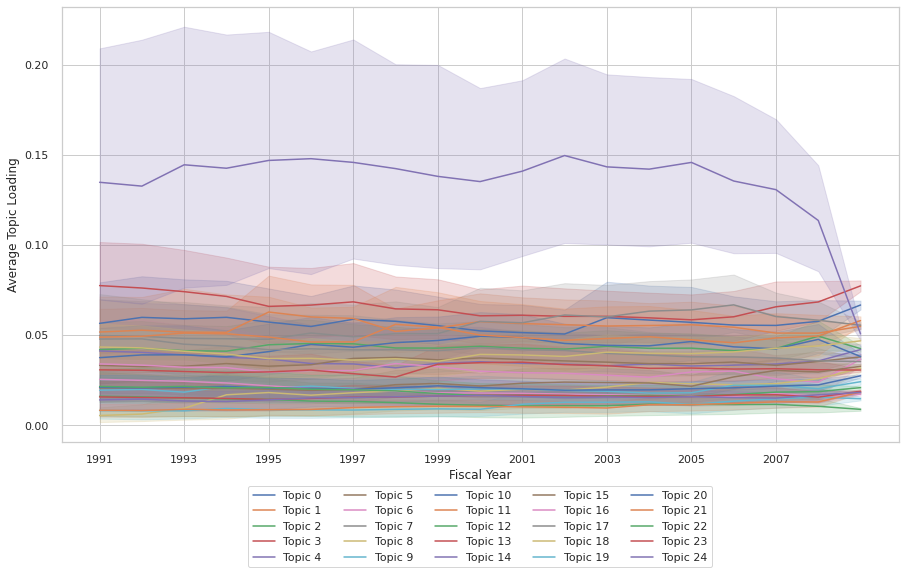

In [226]:
sns.set_theme(style='whitegrid')
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

for i in range(TOPICS):
    sns.lineplot(x='fyear', y=f'topic_{i}', data=df_model, ax=ax, label=f"Topic {i}")

plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(.5, -.3))
ax.set_xticks(range(int(df_model.fyear.min()), int(df_model.fyear.max()), 2))
ax.set_ylabel("Average Topic Loading")
ax.set_xlabel("Fiscal Year")

In [235]:
df_model.groupby('fyear')[df_model.S("topic*")].mean().T

fyear,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
topic_0,0.057,0.060,0.059,0.060,0.057,0.055,0.059,0.058,0.055,0.052,0.051,0.051,0.060,0.058,0.057,0.056,0.055,0.058,0.067
topic_1,0.052,0.053,0.052,0.052,0.063,0.060,0.059,0.052,0.054,0.057,0.056,0.056,0.055,0.055,0.056,0.054,0.051,0.051,0.055
topic_2,0.042,0.043,0.041,0.041,0.045,0.045,0.045,0.043,0.043,0.044,0.043,0.042,0.044,0.043,0.043,0.041,0.043,0.049,0.043
topic_3,0.077,0.076,0.074,0.071,0.066,0.067,0.068,0.065,0.064,0.061,0.061,0.060,0.060,0.060,0.058,0.060,0.066,0.068,0.077
topic_4,0.041,0.040,0.039,0.038,0.037,0.034,0.034,0.032,0.034,0.035,0.034,0.034,0.033,0.034,0.033,0.033,0.034,0.036,0.042
topic_5,0.033,0.033,0.033,0.034,0.033,0.034,0.037,0.038,0.036,0.037,0.036,0.036,0.035,0.034,0.034,0.035,0.033,0.035,0.038
topic_6,0.034,0.033,0.032,0.032,0.029,0.030,0.030,0.034,0.032,0.030,0.029,0.029,0.028,0.027,0.030,0.030,0.026,0.024,0.037
topic_7,0.050,0.049,0.048,0.048,0.048,0.051,0.049,0.051,0.051,0.058,0.057,0.061,0.060,0.063,0.064,0.067,0.060,0.058,0.055
topic_8,0.005,0.006,0.009,0.017,0.018,0.017,0.018,0.019,0.021,0.019,0.020,0.020,0.021,0.024,0.023,0.023,0.023,0.026,0.032
topic_9,0.019,0.020,0.018,0.022,0.021,0.022,0.021,0.020,0.020,0.020,0.020,0.019,0.019,0.018,0.018,0.022,0.022,0.020,0.024
